In [ ]:



from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
#import torch.index_select
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

## **b.** Modify the code to run on co-lab without any new features.

In [ ]:
import gdown
id = "1gCi9-t4dunJIA9zRF4jfBv_n3EEX-2y7" #gdrive sharing id of Data zip file
gdown.download(id = id)


Downloading...
From: https://drive.google.com/uc?id=1gCi9-t4dunJIA9zRF4jfBv_n3EEX-2y7
To: /content/hymenoptera_data.zip
100%|██████████| 47.3M/47.3M [00:00<00:00, 201MB/s]


'hymenoptera_data.zip'

Modified the importing style of data, anyone can access using this id where the data was located in our google drive

Ref: 
https://pypi.org/project/gdown/
,
https://youtu.be/Mq8-WdcnzVo

In [ ]:
!unzip -u "/content/hymenoptera_data.zip" -d "/content" #unzipping the data and storing it here in the colab itself

Archive:  /content/hymenoptera_data.zip
   creating: /content/hymenoptera_data/
   creating: /content/hymenoptera_data/train/
   creating: /content/hymenoptera_data/train/ants/
  inflating: /content/hymenoptera_data/train/ants/0013035.jpg  
  inflating: /content/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: /content/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: /content/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: /content/hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: /content/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: /content/hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: /content/hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: /content/hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: /content/hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: /content/hymenoptera_data/train/ants/136029165

ref: https://stackoverflow.com/questions/49685924/extract-google-drive-zip-from-google-colab-notebook

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/hymenoptera_data' #modified data directory of the folder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

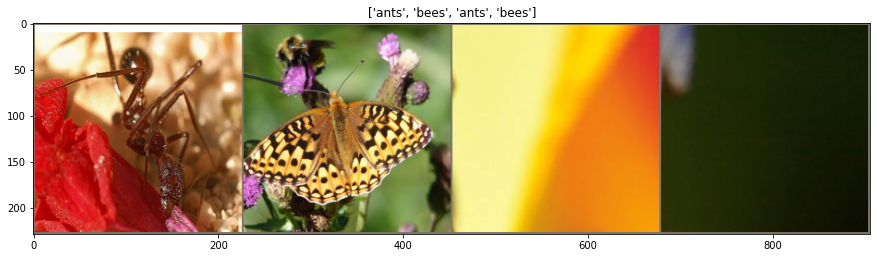

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = (15,8))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
plt.show()

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    #edited
    #print(train_Loss)
    #print(Ep)
    #print(train_Accuracy)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize = (4,2))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet (Gradient on)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6305 Acc: 0.6598
val Loss: 0.1978 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.4090 Acc: 0.8361
val Loss: 0.2210 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.5068 Acc: 0.7910
val Loss: 0.2572 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.5218 Acc: 0.8074
val Loss: 0.3425 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.4832 Acc: 0.8197
val Loss: 0.3048 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.3642 Acc: 0.8770
val Loss: 0.2322 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.6341 Acc: 0.7459
val Loss: 0.3287 Acc: 0.8627

Epoch 7/24
----------
train Loss: 0.3127 Acc: 0.8607
val Loss: 0.2343 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.2482 Acc: 0.9016
val Loss: 0.2226 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.2644 Acc: 0.8770
val Loss: 0.2018 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2711 Acc: 0.8893
val Loss: 0.2067 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.2571 Acc: 0.8975
val Loss: 0.1817 Acc: 0.9150

Ep

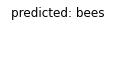

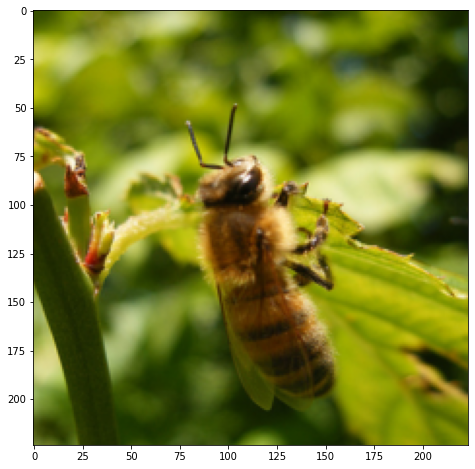

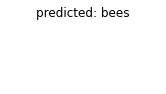

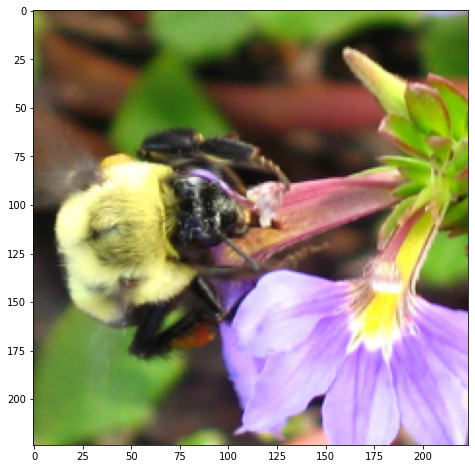

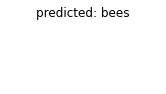

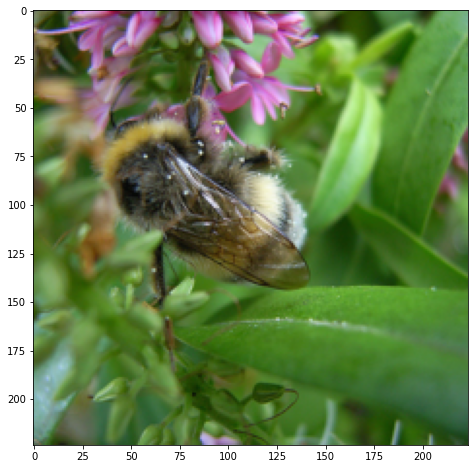

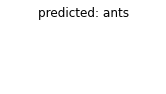

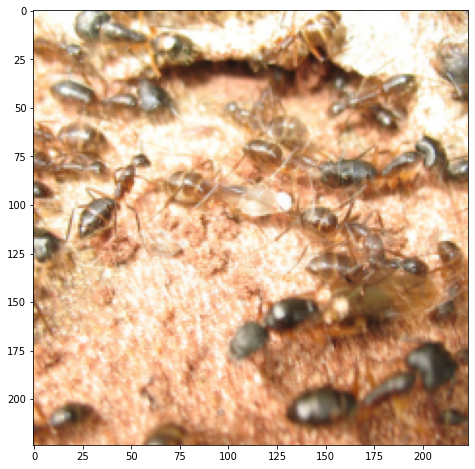

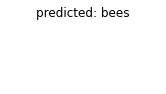

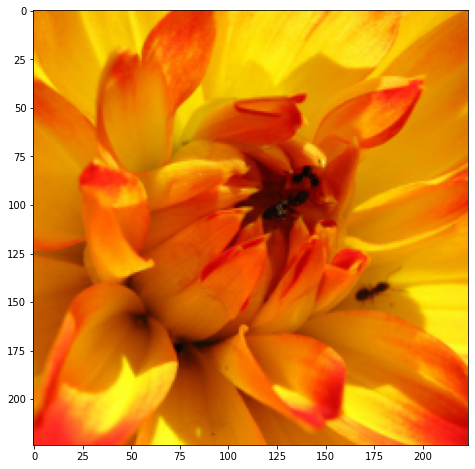

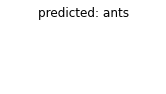

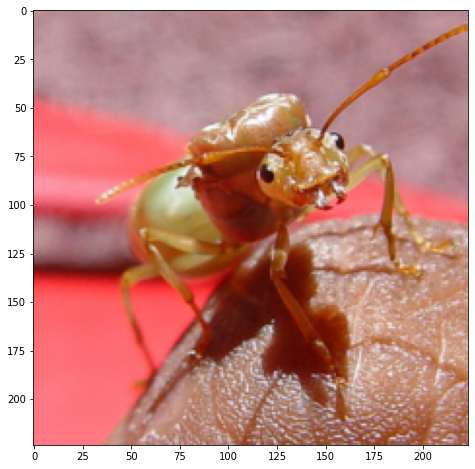

In [ ]:
visualize_model(model_ft)

ConvNet as fixed feature extractor (Gradient off during BP)

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5627 Acc: 0.7049
val Loss: 0.2867 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.4990 Acc: 0.7500
val Loss: 0.1809 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.6410 Acc: 0.7500
val Loss: 0.1979 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4215 Acc: 0.8115
val Loss: 0.3882 Acc: 0.8431

Epoch 4/24
----------
train Loss: 0.4024 Acc: 0.8279
val Loss: 0.1869 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.3853 Acc: 0.8197
val Loss: 0.2714 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.4485 Acc: 0.8320
val Loss: 0.1748 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3875 Acc: 0.8074
val Loss: 0.1752 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3455 Acc: 0.8689
val Loss: 0.1844 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3336 Acc: 0.8443
val Loss: 0.1884 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.4650 Acc: 0.8033
val Loss: 0.1778 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3294 Acc: 0.8770
val Loss: 0.1811 Acc: 0.9346

Ep

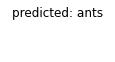

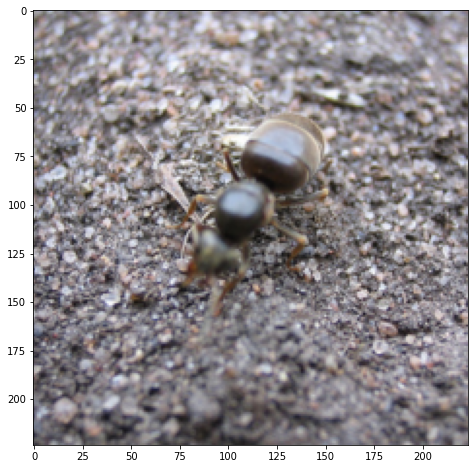

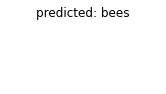

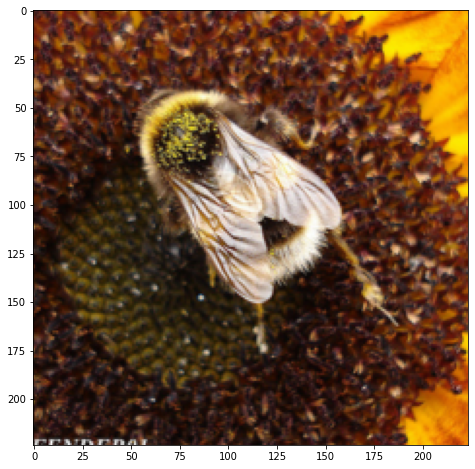

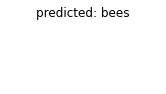

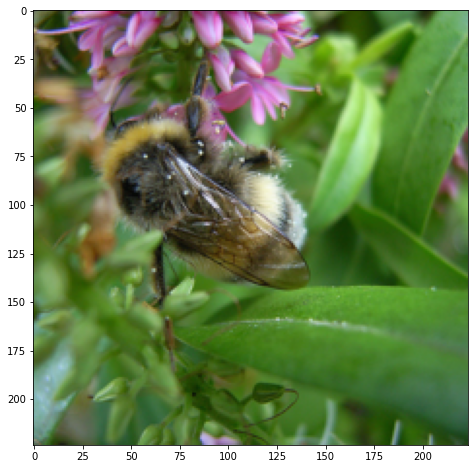

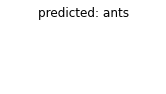

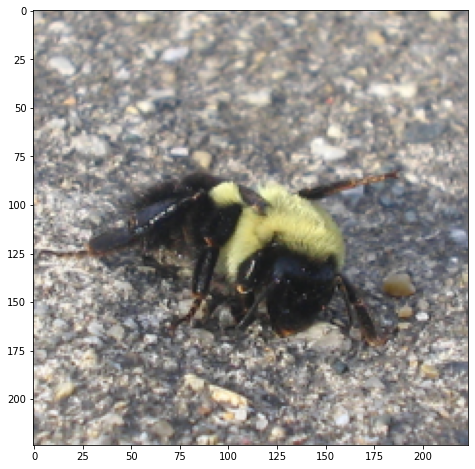

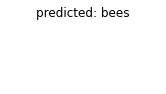

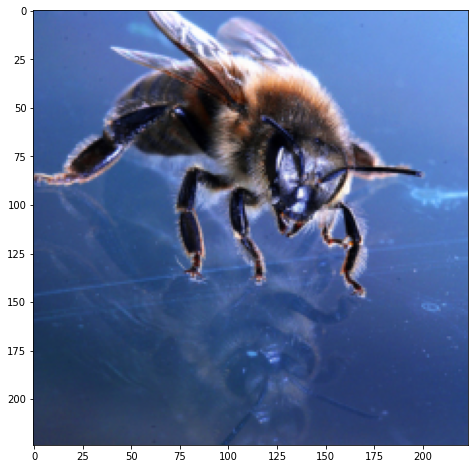

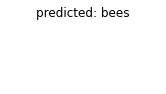

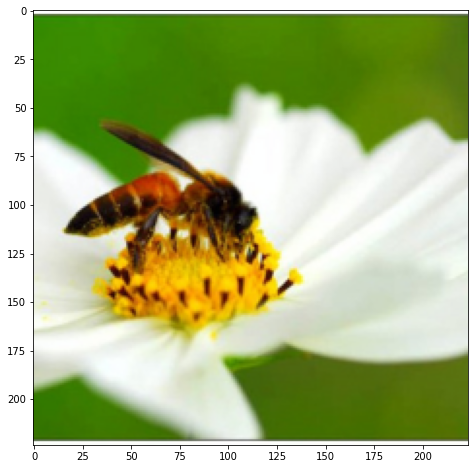

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## **c.** Modify the code to plot validation loss and accuracy after every training epoch.

In [ ]:
from torch._C import Size
from IPython.core.pylabtools import figsize
def train_model_plot(model, criterion, optimizer, scheduler, num_epochs= 6):
  
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_loss =  1
  #edited
  train_Loss = []
  train_Accuracy = []
  val_Loss = []
  val_Accuracy = []
  Ep = []
  #

  for epoch in range(num_epochs):
      print(f'Epoch {epoch}/{num_epochs - 1}')
      print('-' * 10)

      Ep.append(epoch)

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)
                  #print("loss= ",loss)

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              # statistics
              running_loss += loss.item() * inputs.size(0)
              #print("run_loss= ",running_loss)
              running_corrects += torch.sum(preds == labels.data)
              #print("run_corrects = ", running_corrects)

          if phase == 'train':
              scheduler.step()

          epoch_loss = running_loss / dataset_sizes[phase]
          #print("run_loss= ",running_loss)
          epoch_acc = running_corrects.double() / dataset_sizes[phase]
          #print("epoch_acc = ", epoch_acc)

          #edited

          if phase == 'val': 

            val_Loss.append(float(f'{epoch_loss:.4f}')) #getting the validation loss
            val_Accuracy.append(float(f'{epoch_acc:.4f}'))      #getting the validation accuracy         

          #elif phase == 'train':
            #train_Loss.append(f'{epoch_loss:.4f}')
            #train_Accuracy.append(f'{epoch_acc:.4f}')
          #


          print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            # deep copy the model
          if phase == 'val' and epoch_loss < best_loss:
              best_loss = epoch_loss

          if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())


              best_model_wts = copy.deepcopy(model.state_dict())            
      
      print()

  time_elapsed = time.time() - since

  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s') 
  print(f'Best val Acc: {best_acc:4f}')
  print(f'Best val loss: {best_loss:4f}')

  #edited
  print()
  #print(train_Loss)
  #print(Ep)
  #print(train_Accuracy)
  print("val loss: ", val_Loss)
  print("val Accuracy: ",val_Accuracy)

  #ploting
  
  fig, (ax1, ax2) = plt.subplots(2, figsize = (12, 8))
  ax1.plot(val_Loss)
  ax1.set_title('Validation Loss', size = 20)
  ax1.set_ylabel('loss', size = 15)

  ax2.plot(val_Accuracy)
  ax2.set_title('Validation Accuracy', size = 20)
  ax2.set_ylabel('Accuracy', size = 15)
  plt.xlabel('Epochs', Size = 15)
  fig.tight_layout()
  plt.show()
  #

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

Epoch 0/24
----------
train Loss: 0.4073 Acc: 0.8525
val Loss: 0.2720 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.3913 Acc: 0.8238
val Loss: 0.2631 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.4244 Acc: 0.8443
val Loss: 0.2929 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.3644 Acc: 0.8566
val Loss: 0.2369 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.3851 Acc: 0.8320
val Loss: 0.2363 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.4080 Acc: 0.8320
val Loss: 0.2868 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.3975 Acc: 0.8279
val Loss: 0.2624 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.3980 Acc: 0.8320
val Loss: 0.2634 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3546 Acc: 0.8320
val Loss: 0.2496 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.2832 Acc: 0.9057
val Loss: 0.2421 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.4034 Acc: 0.8238
val Loss: 0.2484 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.4267 Acc: 0.8361
val Loss: 0.2153 Acc: 0.9281

Ep

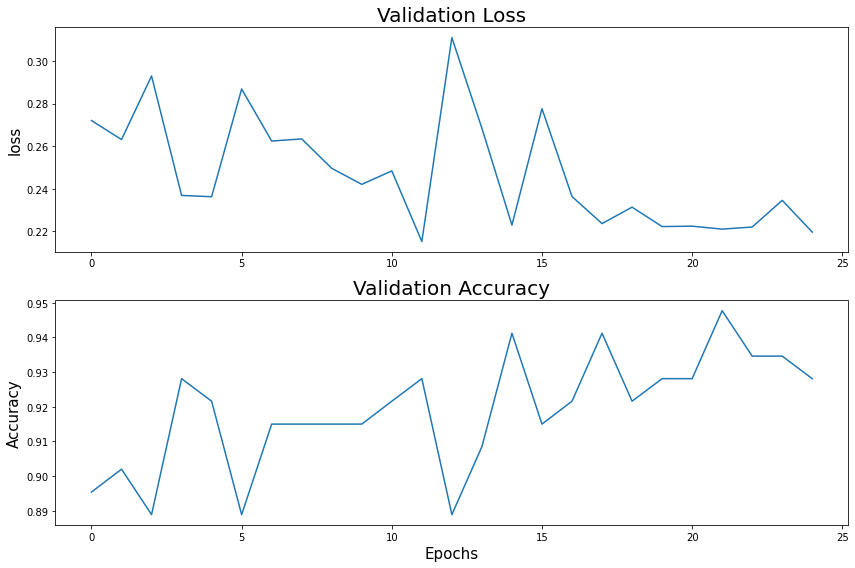

In [ ]:
model_ft_plot = train_model_plot(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25) #finetuning the convonet

Loss and accrarcy changes for each epoch

Epoch 0/24
----------
train Loss: 0.4166 Acc: 0.8361
val Loss: 0.2593 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.3300 Acc: 0.8607
val Loss: 0.1921 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.2644 Acc: 0.8689
val Loss: 0.1882 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.3458 Acc: 0.8402
val Loss: 0.1888 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.2614 Acc: 0.8689
val Loss: 0.1840 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.3390 Acc: 0.8689
val Loss: 0.2182 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3211 Acc: 0.8770
val Loss: 0.2199 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3670 Acc: 0.8320
val Loss: 0.2062 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3996 Acc: 0.8115
val Loss: 0.2152 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3558 Acc: 0.8443
val Loss: 0.1993 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3043 Acc: 0.8811
val Loss: 0.2087 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3527 Acc: 0.8320
val Loss: 0.1913 Acc: 0.9477

Ep

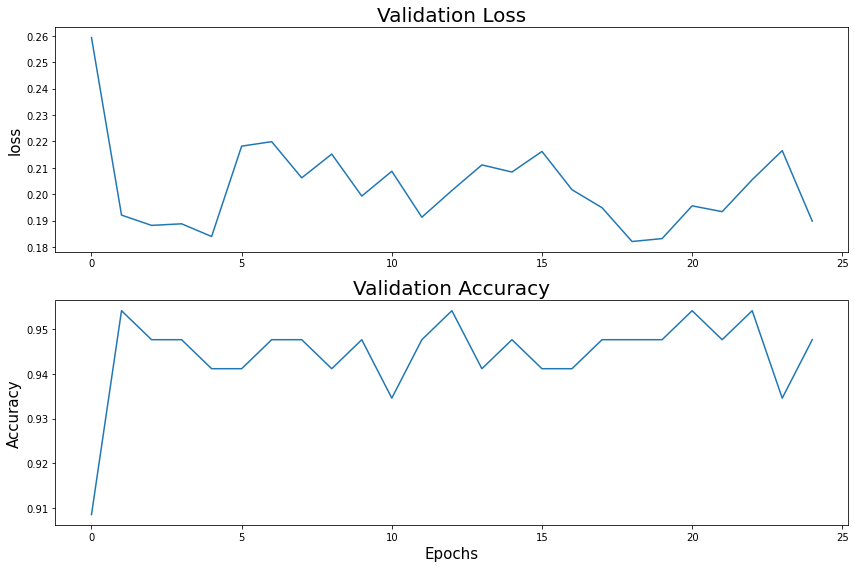

In [ ]:
model_conv_plot = train_model_plot(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25) #convonet as feature 

### **d.** Change the learning rate, momentum, and number of epochs at least three times to see the net effect on final validation loss and accuracy and its speed of convergence.https://pytorch.org/docs/stable/optim.html 

In [ ]:

from torch._C import Size
from IPython.core.pylabtools import figsize
def training_model(model, criterion, optimizer, scheduler, num_epochs): #modified function 
  
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_loss =  1
  #edited
  train_Loss = []
  train_Accuracy = []
  val_Loss = []
  val_Accuracy = []
  Ep = []
  #

  for epoch in range(num_epochs):
     # print(f'Epoch {epoch}/{num_epochs - 1}')
      #print('-' * 10)

      
      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              # statistics
              running_loss += loss.item() * inputs.size(0)
 
              running_corrects += torch.sum(preds == labels.data)


          if phase == 'train':
              scheduler.step()

          epoch_loss = running_loss / dataset_sizes[phase]

          epoch_acc = running_corrects.double() / dataset_sizes[phase]


          #edited

          if phase == 'val':

            val_Loss.append(float(f'{epoch_loss:.4f}'))
            val_Accuracy.append(float(f'{epoch_acc:.4f}'))              

          #elif phase == 'train':
            #train_Loss.append(f'{epoch_loss:.4f}')
            #train_Accuracy.append(f'{epoch_acc:.4f}')
          #


          #print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            # deep copy the model
          if phase == 'val' and epoch_loss < best_loss:
              best_loss = epoch_loss

          if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())


              best_model_wts = copy.deepcopy(model.state_dict())            
      
      #print()

  time_elapsed = time.time() - since

  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')
  print(f'Best val loss: {best_loss:4f}')

  #edited
  print()
  #print(train_Loss)
  
  #print(train_Accuracy)
  #print("val loss: ", val_Loss)
  #print("val Accuracy: ",val_Accuracy)
  #

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, val_Loss, val_Accuracy

### Plotting function for different epochs, momentum and learning rate

In [ ]:
def Ploting(Loss, Accuracy):
  fig, (ax1, ax2) = plt.subplots(2, figsize = (12, 8))
  for i in  Loss:
    ax1.plot(Loss[i])
  ax1.set_title('Validation Loss', size = 20)
  ax1.set_ylabel('loss', size = 15)

  for i in  Accuracy:
    ax2.plot(Accuracy[i])
  ax2.set_title('Validation Accuracy', size = 20)
  ax2.set_ylabel('Accuracy', size = 15)


  plt.xlabel('Epochs', Size = 15)
  fig.tight_layout()
  plt.show()

Didn't find functions or code from other websites, so, created own functions from exsiting code.

In [ ]:
def Param_conv(LearningRate, Momentum, epoch): # ConvNet as fixed feature extractor with different parameters

  model_conv = torchvision.models.resnet18(pretrained=True)
  for param in model_conv.parameters():
      param.requires_grad = False

  # Parameters of newly constructed modules have requires_grad=True by default
  num_ftrs = model_conv.fc.in_features
  model_conv.fc = nn.Linear(num_ftrs, 2)

  model_conv = model_conv.to(device)

  criterion = nn.CrossEntropyLoss()
  model = model_conv

  import pandas as pd


  for k in range(len(epoch)):

    V_Loss = pd.DataFrame(columns=[_ for _ in range(epoch[k])]) #for ploting
    V_Acc = pd.DataFrame(columns=[_ for _ in range(epoch[k])])

    for i in range(len(LearningRate)):
      
      for j in range(len(Momentum)):

        print("For learning rate = ", LearningRate[i], "and", " Momentum = ", Momentum[j])
        # Observe that only parameters of final layer are being optimized as
        # opposed to before.
        optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=LearningRate[i], momentum=Momentum[j]) #for varying momentum and llearning rate one model would be created for each with given epochs
          # Decay LR by a factor of 0.1 every 5 epochs
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.1)

        model_conv, Loss, Accuracy = training_model(model, criterion,optimizer_conv,exp_lr_scheduler, num_epochs=epoch[k])
        V_Loss.loc[len(V_Loss)] = Loss
        V_Acc.loc[len(V_Acc)] = Accuracy
    Ploting(V_Loss, V_Acc)
    #print("Validation Loss")
    #print(V_Loss)
    #print("Validation Accuracy)
    #print(V_Acc)
  return model_conv

For learning rate =  0.01 and  Momentum =  0.7
Training complete in 0m 12s
Best val Acc: 0.947712
Best val loss: 0.239989

For learning rate =  0.01 and  Momentum =  0.8
Training complete in 0m 12s
Best val Acc: 0.947712
Best val loss: 0.378028

For learning rate =  0.01 and  Momentum =  0.9
Training complete in 0m 12s
Best val Acc: 0.954248
Best val loss: 0.701612

For learning rate =  0.001 and  Momentum =  0.7
Training complete in 0m 12s
Best val Acc: 0.947712
Best val loss: 0.720610

For learning rate =  0.001 and  Momentum =  0.8
Training complete in 0m 12s
Best val Acc: 0.941176
Best val loss: 0.765689

For learning rate =  0.001 and  Momentum =  0.9
Training complete in 0m 12s
Best val Acc: 0.947712
Best val loss: 0.617880

For learning rate =  0.0001 and  Momentum =  0.7
Training complete in 0m 12s
Best val Acc: 0.954248
Best val loss: 0.687427

For learning rate =  0.0001 and  Momentum =  0.8
Training complete in 0m 12s
Best val Acc: 0.947712
Best val loss: 0.735423

For learn

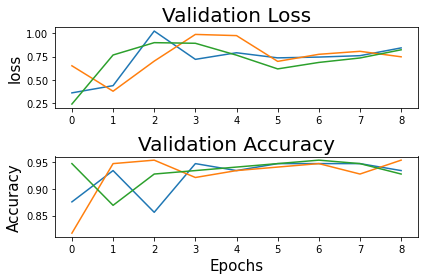

For learning rate =  0.01 and  Momentum =  0.7
Training complete in 0m 21s
Best val Acc: 0.954248
Best val loss: 0.528058

For learning rate =  0.01 and  Momentum =  0.8
Training complete in 0m 21s
Best val Acc: 0.947712
Best val loss: 0.611142

For learning rate =  0.01 and  Momentum =  0.9
Training complete in 0m 21s
Best val Acc: 0.934641
Best val loss: 0.832432

For learning rate =  0.001 and  Momentum =  0.7
Training complete in 0m 22s
Best val Acc: 0.947712
Best val loss: 0.757992

For learning rate =  0.001 and  Momentum =  0.8
Training complete in 0m 21s
Best val Acc: 0.941176
Best val loss: 0.699114

For learning rate =  0.001 and  Momentum =  0.9
Training complete in 0m 21s
Best val Acc: 0.947712
Best val loss: 0.674531

For learning rate =  0.0001 and  Momentum =  0.7
Training complete in 0m 21s
Best val Acc: 0.954248
Best val loss: 0.757149

For learning rate =  0.0001 and  Momentum =  0.8
Training complete in 0m 24s
Best val Acc: 0.947712
Best val loss: 0.745060

For learn

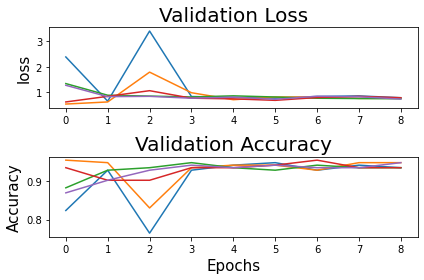

For learning rate =  0.01 and  Momentum =  0.7
Training complete in 0m 33s
Best val Acc: 0.947712
Best val loss: 0.538348

For learning rate =  0.01 and  Momentum =  0.8
Training complete in 0m 33s
Best val Acc: 0.954248
Best val loss: 0.501087

For learning rate =  0.01 and  Momentum =  0.9
Training complete in 0m 33s
Best val Acc: 0.947712
Best val loss: 0.595809

For learning rate =  0.001 and  Momentum =  0.7
Training complete in 0m 33s
Best val Acc: 0.941176
Best val loss: 0.574241

For learning rate =  0.001 and  Momentum =  0.8
Training complete in 0m 33s
Best val Acc: 0.954248
Best val loss: 0.614464

For learning rate =  0.001 and  Momentum =  0.9
Training complete in 0m 35s
Best val Acc: 0.941176
Best val loss: 0.616866

For learning rate =  0.0001 and  Momentum =  0.7
Training complete in 0m 34s
Best val Acc: 0.934641
Best val loss: 0.650395

For learning rate =  0.0001 and  Momentum =  0.8
Training complete in 0m 33s
Best val Acc: 0.947712
Best val loss: 0.646555

For learn

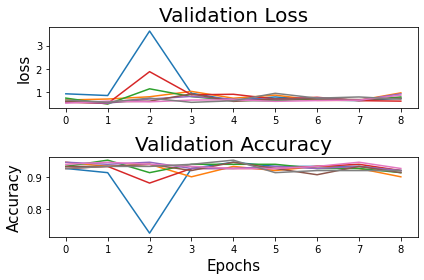

In [ ]:
#diff parameters
LearningRate = [0.01, 0.001, 1e-4]
Momentum = [0.7, 0.8,0.9]
epoch = [8, 15, 25]
model = Param_conv(LearningRate, Momentum, epoch)

In [ ]:
def Param_ft(LearningRate, Momentum, epoch): #ConvNet as fixed feature extractor with different parameters


  model_ft = models.resnet18(pretrained=True)


  num_ftrs = model_ft.fc.in_features
  model_ft.fc = nn.Linear(num_ftrs, 2)

  model_ft = model_ft.to(device)

  criterion = nn.CrossEntropyLoss()
  model = model_ft

  import pandas as pd


  for k in range(len(epoch)):
    V_Loss = pd.DataFrame(columns=[_ for _ in range(epoch[k])])
    V_Acc = pd.DataFrame(columns=[_ for _ in range(epoch[k])]) 
    for i in range(len(LearningRate)):

      for j in range(len(Momentum)):

        print("For learning rate = ", LearningRate[i], "and", " Momentum = ", Momentum[j])
        # Observe that only parameters of final layer are being optimized as
        # opposed to before.
        optimizer_ft = optim.SGD(model_ft.parameters(), lr=LearningRate[i], momentum=Momentum[j])
        # Decay LR by a factor of 0.1 every 7 epochs
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

        model_ft, Loss, Accuracy = training_model(model, criterion,optimizer_ft,exp_lr_scheduler, num_epochs=epoch[k])
        V_Loss.loc[len(V_Loss)] = Loss
        V_Acc.loc[len(V_Acc)] = Accuracy
    #print("Validation Loss")
    #print(V_Loss)
    #print("Validation Accuracy)
    #print(V_Acc)
    Ploting(V_Loss, V_Acc)
  return model_ft

For learning rate =  0.01 and  Momentum =  0.7
Training complete in 1m 26s
Best val Acc: 0.666667
Best val loss: 0.688115

For learning rate =  0.01 and  Momentum =  0.8
Training complete in 1m 29s
Best val Acc: 0.686275
Best val loss: 0.627626

For learning rate =  0.01 and  Momentum =  0.9
Training complete in 1m 23s
Best val Acc: 0.666667
Best val loss: 0.741784

For learning rate =  0.001 and  Momentum =  0.7
Training complete in 1m 26s
Best val Acc: 0.522876
Best val loss: 0.685938

For learning rate =  0.001 and  Momentum =  0.8
Training complete in 1m 27s
Best val Acc: 0.522876
Best val loss: 0.693660

For learning rate =  0.001 and  Momentum =  0.9
Training complete in 1m 29s
Best val Acc: 0.594771
Best val loss: 0.702219

For learning rate =  0.0001 and  Momentum =  0.7
Training complete in 1m 28s
Best val Acc: 0.522876
Best val loss: 0.699145

For learning rate =  0.0001 and  Momentum =  0.8
Training complete in 1m 27s
Best val Acc: 0.477124
Best val loss: 0.702158

For learn

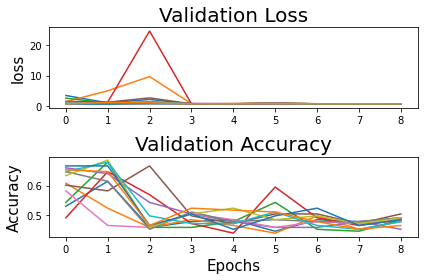

For learning rate =  0.01 and  Momentum =  0.7
Training complete in 2m 23s
Best val Acc: 0.601307
Best val loss: 0.667260

For learning rate =  0.01 and  Momentum =  0.8
Training complete in 2m 26s
Best val Acc: 0.640523
Best val loss: 0.670659

For learning rate =  0.01 and  Momentum =  0.9
Training complete in 2m 21s
Best val Acc: 0.673203
Best val loss: 0.641375

For learning rate =  0.001 and  Momentum =  0.7
Training complete in 2m 20s
Best val Acc: 0.679739
Best val loss: 0.640964

For learning rate =  0.001 and  Momentum =  0.8


In [ ]:
LearningRate = [0.01, 0.001, 1e-4]
Momentum = [0.7, 0.8,0.9]
epoch = [12, 20, 24]
model = Param_ft(LearningRate, Momentum, epoch)

Observed good model at momenntum = 0.8 and learning rate = 0.0001

In [ ]:
def wd_ft(weight_decay, epoch):
  model_ft = models.resnet18(pretrained=True)
  num_ftrs = model_ft.fc.in_features
  # Here the size of each output sample is set to 2.
  # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
  model_ft.fc = nn.Linear(num_ftrs, 2)

  model_ft = model_ft.to(device)

  criterion = nn.CrossEntropyLoss()
  model = model_ft
  import pandas as pd
  v_loss = pd.DataFrame(columns=[_ for _ in range(epoch)])
  v_acc = pd.DataFrame(columns=[_ for _ in range(epoch)])
  for i in range(len(weight_decay)):
    print("For weight Decay: " , weight_decay[i])

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.8, weight_decay= weight_decay[i]) #for varying weight decay one model would be created for each with given epochs

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    model_ft, Loss, Accuracy = training_model(model, criterion,optimizer_ft,exp_lr_scheduler, num_epochs=epoch)
    v_loss.loc[len(v_loss)] = Loss
    v_acc.loc[len(v_acc)] = Accuracy
  print(v_loss)
  print(v_acc)
  Ploting(v_loss, v_acc)
  return model_ft

In [ ]:
weight_decay = [0.1, 0.2, 0.5, 0.7, 0.9]
epoch = 25
model = wd_ft(weight_decay, epoch)

Observed good model at weight decay of value 0.2